In [29]:
import os
import nltk
from nltk.corpus import words
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import string
import csv
from tqdm import tqdm
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import random
import time
from tqdm import tqdm

In [30]:
# nltk.download('words')

# word_list = words.words()

# print(f"Total words available: {len(word_list)}")

# random.shuffle(word_list)
# selected_words = word_list[:100000]

# output_dir = 'dataset'
# os.makedirs(output_dir, exist_ok=True)

# img_width, img_height = 256, 64

# font_path = 'arial.ttf'  
# initial_font_size = 48

In [31]:
# def render_word_to_image(word, idx):
#     font = ImageFont.truetype(font_path, initial_font_size)
#     img = Image.new('RGB', (img_width, img_height), color='white')
#     draw = ImageDraw.Draw(img)

#     bbox = draw.textbbox((0, 0), word, font=font)
#     text_width = bbox[2] - bbox[0]
#     text_height = bbox[3] - bbox[1]
#     x = (img_width - text_width) / 2
#     y = (img_height - text_height) / 2

#     while text_width > img_width - 10:
#         font_size_adjusted = font.size - 1
#         if font_size_adjusted < 10:
#             break  
#         font = ImageFont.truetype(font_path, font_size_adjusted)
#         bbox = draw.textbbox((0, 0), word, font=font)
#         text_width = bbox[2] - bbox[0]
#         text_height = bbox[3] - bbox[1]
#         x = (img_width - text_width) / 2
#         y = (img_height - text_height) / 2

#     draw.text((x, y), word, fill='black', font=font)

#     img.save(os.path.join(output_dir, f'{idx}_{word}.png'))

# start_time = time.time()

# for idx, word in enumerate(tqdm(selected_words, desc="Generating images", unit="image")):
#     render_word_to_image(word, idx)

# end_time = time.time()

# total_time = end_time - start_time
# print(total_time)

In [32]:
# def display_image(idx, word):
#     img_path = os.path.join(output_dir, f'{idx}_{word}.png')
#     img = Image.open(img_path)
#     plt.imshow(img)
#     plt.axis('off')
#     plt.title(f'Image for word: {word}')
#     plt.show()

# for i in random.sample(range(len(selected_words)), 3):
#     display_image(i, selected_words[i])

In [33]:
# labels_path = os.path.join(output_dir, 'labels.csv')

# with open(labels_path, 'w', newline='') as csvfile:
#     label_writer = csv.writer(csvfile)
#     label_writer.writerow(['filename', 'word']) 
#     for idx, word in enumerate(selected_words):
#         filename = f'{idx}_{word}.png'
#         label_writer.writerow([filename, word])

In [34]:
charset = '-' + string.ascii_letters + string.digits + string.punctuation + ' '
char_to_idx = {char: idx for idx, char in enumerate(charset)}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}
num_classes = len(charset)

In [35]:
class OCRDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        import pandas as pd
        self.annotations = pd.read_csv(csv_file, dtype={'filename': str, 'word': str})
        self.annotations['word'] = self.annotations['word'].fillna('')
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_name).convert('L')  
        word = self.annotations.iloc[idx, 1]

        if not isinstance(word, str):
            word = str(word)

        word = word.lower()

        if self.transform:
            image = self.transform(image)
        label = [char_to_idx.get(char, 0) for char in word if char in char_to_idx]

        return image, torch.tensor(label, dtype=torch.long)

In [36]:
transform = transforms.Compose([
    transforms.Resize((64, 256)), 
    transforms.ToTensor(),        
    transforms.Normalize((0.5,), (0.5,))
])

In [37]:
def collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images, 0)
    label_lengths = torch.tensor([len(label) for label in labels], dtype=torch.long)
    labels = torch.cat(labels)
    return images, labels, label_lengths

In [38]:
labels_path = r"C:\Users\raaga\OneDrive\Desktop\IIIT-H\3-1\SMAI\smai-m24-assignments-rraagav\assignments\5\figures\labels.csv"
output_dir = r"C:\Users\raaga\OneDrive\Desktop\IIIT-H\3-1\SMAI\smai-m24-assignments-rraagav\data\interim\5\dataset"

dataset = OCRDataset(csv_file=labels_path, root_dir=output_dir, transform=transform)

from sklearn.model_selection import train_test_split

indices = list(range(len(dataset)))
train_indices, val_test_indices = train_test_split(indices, test_size=0.2, random_state=42)
val_indices, test_indices = train_test_split(val_test_indices, test_size=0.5, random_state=42)

from torch.utils.data import Subset

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0, collate_fn=collate_fn)

In [39]:
class CNNEncoder(nn.Module):
    def __init__(self):
        super(CNNEncoder, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),  
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),  

            nn.Conv2d(64, 128, kernel_size=3, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2), 
        )

    def forward(self, x):
        x = self.cnn(x)
        return x

In [40]:
class RNNDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNNDecoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.log_softmax = nn.LogSoftmax(dim=2) 
    
    def forward(self, x):
        self.lstm.flatten_parameters()
        x, _ = self.lstm(x)
        x = self.fc(x)
        x = self.log_softmax(x)  
        return x

In [41]:
class CRNN(nn.Module):
    def __init__(self, num_classes):
        super(CRNN, self).__init__()
        self.encoder = CNNEncoder()
        self.fc = nn.Linear(2048, 128)
        self.decoder = RNNDecoder(input_size=128, hidden_size=256, num_classes=num_classes)

    def forward(self, x):
        x = self.encoder(x)
        b, c, h, w = x.size()
        x = x.permute(0, 3, 1, 2)  
        x = x.view(b, w, c * h)    

        x = self.fc(x)             

        x = self.decoder(x)        
        x = x.permute(1, 0, 2)
        return x

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CRNN(num_classes=num_classes).to(device)
criterion = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [43]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    print("Starting training...")
    running_loss = 0.0
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch}", unit="batch") as pbar:
        for batch_idx, (images, labels, label_lengths) in enumerate(train_loader):
            # print(f"Processing batch {batch_idx+1}/{len(train_loader)}")
            images = images.to(device)
            labels = labels.to(device)
            label_lengths = label_lengths.to(device)
            optimizer.zero_grad()

            outputs = model(images)  #[T, B, num_classes]
            batch_size = images.size(0)
            input_lengths = torch.full(size=(batch_size,), fill_value=outputs.size(0), dtype=torch.long).to(device)

            loss = criterion(outputs, labels, input_lengths, label_lengths)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            pbar.set_postfix(loss=loss.item())
            pbar.update(1)

            if batch_idx % 100 == 0:
                print(f'Epoch {epoch} [{batch_idx * len(images)}/{len(train_loader.dataset)}] Loss: {loss.item():.4f}')

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch} Training Loss: {avg_loss:.4f}")
    return avg_loss

def validate(model, device, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    with tqdm(total=len(val_loader), desc="Validation", unit="batch") as pbar:
        with torch.no_grad():
            for images, labels, label_lengths in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                label_lengths = label_lengths.to(device)
                outputs = model(images)
                batch_size = images.size(0)
                input_lengths = torch.full(size=(batch_size,), fill_value=outputs.size(0), dtype=torch.long).to(device)
                
                loss = criterion(outputs, labels, input_lengths, label_lengths)
                val_loss += loss.item()
                
                pbar.set_postfix(loss=loss.item())
                pbar.update(1)

    val_loss /= len(val_loader)
    print(f'Validation Loss: {val_loss:.4f}')
    return val_loss

In [44]:
sample_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

for images, labels, label_lengths in sample_loader:
    print("Images shape:", images.shape)
    print("Labels:", labels)
    print("Label lengths:", label_lengths)
    break

images, labels, label_lengths = next(iter(train_loader))
images = images.to(device)
outputs = model(images)
print("Model output shape:", outputs.shape)
print("Sample outputs:", outputs[:, 0, :5])  

Images shape: torch.Size([2, 1, 64, 256])
Labels: tensor([18,  5, 22,  5, 14,  5,  5, 18, 20,  5, 12,  5, 16,  1, 20,  8, 25])
Label lengths: tensor([8, 9])
Model output shape: torch.Size([64, 64, 96])
Sample outputs: tensor([[-4.6019, -4.5100, -4.5462, -4.5696, -4.5518],
        [-4.6021, -4.5065, -4.5435, -4.5705, -4.5471],
        [-4.6008, -4.5034, -4.5426, -4.5720, -4.5457],
        [-4.5991, -4.5020, -4.5420, -4.5728, -4.5455],
        [-4.5975, -4.5010, -4.5416, -4.5735, -4.5460],
        [-4.5959, -4.5000, -4.5413, -4.5745, -4.5469],
        [-4.5942, -4.4986, -4.5409, -4.5758, -4.5481],
        [-4.5920, -4.4964, -4.5406, -4.5777, -4.5498],
        [-4.5891, -4.4929, -4.5401, -4.5804, -4.5517],
        [-4.5850, -4.4875, -4.5393, -4.5837, -4.5531],
        [-4.5803, -4.4799, -4.5340, -4.5849, -4.5540],
        [-4.5793, -4.4801, -4.5175, -4.5895, -4.5444],
        [-4.5782, -4.4761, -4.5001, -4.5903, -4.5391],
        [-4.5700, -4.4749, -4.4930, -4.5946, -4.5492],
        [-4.

In [45]:
images, labels, label_lengths = next(iter(train_loader))
images = images.to(device)
outputs = model(images)
print("Model output shape:", outputs.shape)

Model output shape: torch.Size([64, 64, 96])


In [46]:
def decode_predictions(outputs):
    #[W, B, num_classes]
    outputs = outputs.permute(1, 0, 2)  
    predictions = []
    for output in outputs:
        _, max_indices = torch.max(output, dim=1)
        indices = max_indices.cpu().numpy()
        decoded = []
        prev_idx = -1
        for idx in indices:
            if idx != prev_idx and idx != 0:
                decoded.append(idx)
            prev_idx = idx
        text = ''.join([idx_to_char[idx] for idx in decoded])
        predictions.append(text)
    return predictions

In [47]:
def evaluate(model, device, data_loader):
    model.eval()
    total_correct_chars = 0
    total_chars = 0
    with torch.no_grad():
        for images, labels, label_lengths in data_loader:
            images = images.to(device)
            outputs = model(images)
            predictions = decode_predictions(outputs)
            
            labels_cpu = labels.cpu().numpy()
            label_lengths_cpu = label_lengths.cpu().numpy()
            idx = 0
            ground_truths = []
            for length in label_lengths_cpu:
                word_indices = labels_cpu[idx:idx+length]
                word = ''.join([idx_to_char[i] for i in word_indices])
                ground_truths.append(word)
                idx += length

            for pred, gt in zip(predictions, ground_truths):
                correct_chars = sum(1 for p, g in zip(pred, gt) if p == g)
                total_correct_chars += correct_chars
                total_chars += len(gt)
    ancc = total_correct_chars / total_chars
    print(f'Average Number of Correct Characters: {ancc:.4f}')
    return ancc

In [48]:
def random_baseline(data_loader):
    total_correct_chars = 0
    total_chars = 0
    charset_without_blank = charset[1:] 
    for _, labels, label_lengths in data_loader:
        labels_cpu = labels.cpu().numpy()
        label_lengths_cpu = label_lengths.cpu().numpy()
        idx = 0
        ground_truths = []
        for length in label_lengths_cpu:
            word_indices = labels_cpu[idx:idx+length]
            word = ''.join([idx_to_char[i] for i in word_indices])
            ground_truths.append(word)
            idx += length

        for gt in ground_truths:
            random_pred = ''.join(random.choice(charset_without_blank) for _ in range(len(gt)))
            correct_chars = sum(1 for p, g in zip(random_pred, gt) if p == g)
            total_correct_chars += correct_chars
            total_chars += len(gt)
    ancc = total_correct_chars / total_chars
    print(f'Random Baseline ANCC: {ancc:.4f}')
    return ancc

In [ ]:
num_epochs = 10
best_val_loss = float('inf')
train_losses = []
val_losses = []
val_anccs = []

for epoch in range(1, num_epochs + 1):
    train_loss = train(model, device, train_loader, criterion, optimizer, epoch)
    val_loss = validate(model, device, val_loader, criterion)
    ancc = evaluate(model, device, val_loader)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_anccs.append(ancc)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_crnn_model.pth')

print("Best Val Loss is", best_val_loss)

Starting training...


Epoch 1:   0%|          | 1/1250 [00:00<03:07,  6.64batch/s, loss=28.7]

Epoch 1 [0/80000] Loss: 28.7202


Epoch 1:   8%|▊         | 102/1250 [00:15<02:54,  6.59batch/s, loss=3.19]

Epoch 1 [6400/80000] Loss: 3.1550


Epoch 1:  16%|█▌        | 202/1250 [00:30<02:35,  6.73batch/s, loss=3.12]

Epoch 1 [12800/80000] Loss: 3.0612


Epoch 1:  24%|██▍       | 302/1250 [00:45<02:19,  6.78batch/s, loss=3.08]

Epoch 1 [19200/80000] Loss: 3.1093


Epoch 1:  32%|███▏      | 402/1250 [01:00<02:09,  6.53batch/s, loss=3.06]

Epoch 1 [25600/80000] Loss: 3.0113


Epoch 1:  40%|████      | 502/1250 [01:16<01:54,  6.54batch/s, loss=2.86]

Epoch 1 [32000/80000] Loss: 2.9578


Epoch 1:  48%|████▊     | 601/1250 [01:31<01:56,  5.55batch/s, loss=2.36]

Epoch 1 [38400/80000] Loss: 2.3628


Epoch 1:  56%|█████▌    | 702/1250 [01:50<01:37,  5.65batch/s, loss=0.567]

Epoch 1 [44800/80000] Loss: 0.5306


Epoch 1:  64%|██████▍   | 802/1250 [02:08<01:20,  5.56batch/s, loss=0.269]

Epoch 1 [51200/80000] Loss: 0.1349


Epoch 1:  72%|███████▏  | 902/1250 [02:27<01:05,  5.31batch/s, loss=0.11]  

Epoch 1 [57600/80000] Loss: 0.0676


Epoch 1:  80%|████████  | 1002/1250 [02:45<00:40,  6.19batch/s, loss=0.0476]

Epoch 1 [64000/80000] Loss: 0.0446


Epoch 1:  88%|████████▊ | 1102/1250 [03:01<00:26,  5.59batch/s, loss=0.0237]

Epoch 1 [70400/80000] Loss: 0.0292


Epoch 1:  96%|█████████▌| 1202/1250 [03:18<00:08,  5.69batch/s, loss=0.0143] 

Epoch 1 [76800/80000] Loss: 0.0295


Epoch 1: 100%|██████████| 1250/1250 [03:27<00:00,  6.04batch/s, loss=0.0202] 


Epoch 1 Training Loss: 1.6366


Validation: 100%|██████████| 157/157 [00:16<00:00,  9.56batch/s, loss=0.00887]


Validation Loss: 0.0159
Average Number of Correct Characters: 0.9815
Model saved.
Starting training...


Epoch 2:   0%|          | 2/1250 [00:00<04:02,  5.15batch/s, loss=0.0464] 

Epoch 2 [0/80000] Loss: 0.0094


Epoch 2:   8%|▊         | 102/1250 [00:15<02:38,  7.24batch/s, loss=0.0712]

Epoch 2 [6400/80000] Loss: 0.0759


Epoch 2:  16%|█▌        | 202/1250 [00:29<02:39,  6.58batch/s, loss=0.0317] 

Epoch 2 [12800/80000] Loss: 0.0110


Epoch 2:  24%|██▍       | 302/1250 [00:43<02:09,  7.31batch/s, loss=0.0124] 

Epoch 2 [19200/80000] Loss: 0.0270


Epoch 2:  32%|███▏      | 402/1250 [00:57<01:54,  7.39batch/s, loss=0.00685]

Epoch 2 [25600/80000] Loss: 0.0344


Epoch 2:  40%|████      | 502/1250 [01:11<01:44,  7.16batch/s, loss=0.00522]

Epoch 2 [32000/80000] Loss: 0.0073


Epoch 2:  48%|████▊     | 602/1250 [01:25<01:32,  7.01batch/s, loss=0.00539]

Epoch 2 [38400/80000] Loss: 0.0071


Epoch 2:  56%|█████▌    | 702/1250 [01:40<01:22,  6.64batch/s, loss=0.0084] 

Epoch 2 [44800/80000] Loss: 0.0078


Epoch 2:  64%|██████▍   | 802/1250 [01:54<01:08,  6.54batch/s, loss=0.00611]

Epoch 2 [51200/80000] Loss: 0.0155


Epoch 2:  72%|███████▏  | 902/1250 [02:09<00:51,  6.74batch/s, loss=0.00874]

Epoch 2 [57600/80000] Loss: 0.0087


Epoch 2:  80%|████████  | 1002/1250 [02:24<00:37,  6.68batch/s, loss=0.00421]

Epoch 2 [64000/80000] Loss: 0.0061


Epoch 2:  88%|████████▊ | 1102/1250 [02:40<00:23,  6.29batch/s, loss=0.00761]

Epoch 2 [70400/80000] Loss: 0.0032


Epoch 2:  96%|█████████▌| 1202/1250 [02:56<00:07,  6.19batch/s, loss=0.00644]

Epoch 2 [76800/80000] Loss: 0.0130


Epoch 2: 100%|██████████| 1250/1250 [03:03<00:00,  6.81batch/s, loss=0.0096] 


Epoch 2 Training Loss: 0.0238


Validation: 100%|██████████| 157/157 [00:15<00:00, 10.46batch/s, loss=0.00205]


Validation Loss: 0.0065
Average Number of Correct Characters: 0.9920
Model saved.
Starting training...


Epoch 3:   0%|          | 2/1250 [00:00<03:56,  5.28batch/s, loss=0.00705]

Epoch 3 [0/80000] Loss: 0.0092


Epoch 3:   8%|▊         | 102/1250 [00:14<02:39,  7.19batch/s, loss=0.00236]

Epoch 3 [6400/80000] Loss: 0.0053


Epoch 3:  16%|█▌        | 202/1250 [00:29<02:41,  6.47batch/s, loss=0.00122]

Epoch 3 [12800/80000] Loss: 0.0036


Epoch 3:  24%|██▍       | 302/1250 [00:44<02:20,  6.73batch/s, loss=0.00987] 

Epoch 3 [19200/80000] Loss: 0.0072


Epoch 3:  32%|███▏      | 402/1250 [01:00<02:11,  6.43batch/s, loss=0.0165] 

Epoch 3 [25600/80000] Loss: 0.0025


Epoch 3:  40%|████      | 502/1250 [01:14<01:45,  7.09batch/s, loss=0.0245] 

Epoch 3 [32000/80000] Loss: 0.0226


Epoch 3:  48%|████▊     | 602/1250 [01:28<01:28,  7.29batch/s, loss=0.00456]

Epoch 3 [38400/80000] Loss: 0.0131


Epoch 3:  56%|█████▌    | 702/1250 [01:42<01:15,  7.27batch/s, loss=0.00291]

Epoch 3 [44800/80000] Loss: 0.0143


Epoch 3:  64%|██████▍   | 802/1250 [01:56<01:03,  7.03batch/s, loss=0.0157]  

Epoch 3 [51200/80000] Loss: 0.0038


Epoch 3:  72%|███████▏  | 902/1250 [02:10<00:48,  7.24batch/s, loss=0.00435] 

Epoch 3 [57600/80000] Loss: 0.0196


Epoch 3:  80%|████████  | 1002/1250 [02:23<00:34,  7.26batch/s, loss=0.019] 

Epoch 3 [64000/80000] Loss: 0.0336


Epoch 3:  88%|████████▊ | 1102/1250 [02:37<00:20,  7.16batch/s, loss=0.0208] 

Epoch 3 [70400/80000] Loss: 0.0392


Epoch 3:  96%|█████████▌| 1202/1250 [02:51<00:06,  7.21batch/s, loss=0.0132] 

Epoch 3 [76800/80000] Loss: 0.0037


Epoch 3: 100%|██████████| 1250/1250 [02:58<00:00,  7.00batch/s, loss=0.0234] 


Epoch 3 Training Loss: 0.0178


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.56batch/s, loss=0.00933]


Validation Loss: 0.0072
Average Number of Correct Characters: 0.9896
Starting training...


Epoch 4:   0%|          | 2/1250 [00:00<03:36,  5.78batch/s, loss=0.0232] 

Epoch 4 [0/80000] Loss: 0.0036


Epoch 4:   8%|▊         | 102/1250 [00:14<02:40,  7.16batch/s, loss=0.00998]

Epoch 4 [6400/80000] Loss: 0.0010


Epoch 4:  16%|█▌        | 202/1250 [00:28<02:24,  7.23batch/s, loss=0.00419] 

Epoch 4 [12800/80000] Loss: 0.0020


Epoch 4:  24%|██▍       | 302/1250 [00:42<02:11,  7.22batch/s, loss=0.0113]  

Epoch 4 [19200/80000] Loss: 0.0017


Epoch 4:  32%|███▏      | 402/1250 [00:56<01:56,  7.28batch/s, loss=0.00794] 

Epoch 4 [25600/80000] Loss: 0.0023


Epoch 4:  40%|████      | 502/1250 [01:10<01:43,  7.20batch/s, loss=0.0784]  

Epoch 4 [32000/80000] Loss: 0.0637


Epoch 4:  48%|████▊     | 602/1250 [01:24<01:29,  7.26batch/s, loss=0.00559]

Epoch 4 [38400/80000] Loss: 0.0221


Epoch 4:  56%|█████▌    | 702/1250 [01:38<01:24,  6.49batch/s, loss=0.0086] 

Epoch 4 [44800/80000] Loss: 0.0226


Epoch 4:  64%|██████▍   | 802/1250 [01:53<01:07,  6.62batch/s, loss=0.00512]

Epoch 4 [51200/80000] Loss: 0.0069


Epoch 4:  72%|███████▏  | 902/1250 [02:08<00:52,  6.58batch/s, loss=0.00517]

Epoch 4 [57600/80000] Loss: 0.0110


Epoch 4:  80%|████████  | 1002/1250 [02:22<00:35,  7.04batch/s, loss=0.00382]

Epoch 4 [64000/80000] Loss: 0.0017


Epoch 4:  88%|████████▊ | 1102/1250 [02:37<00:20,  7.24batch/s, loss=0.00174] 

Epoch 4 [70400/80000] Loss: 0.0027


Epoch 4:  96%|█████████▌| 1202/1250 [02:51<00:06,  7.15batch/s, loss=0.00313] 

Epoch 4 [76800/80000] Loss: 0.0006


Epoch 4: 100%|██████████| 1250/1250 [02:58<00:00,  7.02batch/s, loss=0.00496] 


Epoch 4 Training Loss: 0.0166


Validation: 100%|██████████| 157/157 [00:20<00:00,  7.59batch/s, loss=0.000833]


Validation Loss: 0.0031
Average Number of Correct Characters: 0.9958
Model saved.
Starting training...


Epoch 5:   0%|          | 1/1250 [00:00<04:26,  4.69batch/s, loss=0.00186]

Epoch 5 [0/80000] Loss: 0.0022


Epoch 5:   8%|▊         | 101/1250 [00:20<03:53,  4.93batch/s, loss=0.00104] 

Epoch 5 [6400/80000] Loss: 0.0010


Epoch 5:  16%|█▌        | 201/1250 [00:39<03:07,  5.59batch/s, loss=0.00396] 

Epoch 5 [12800/80000] Loss: 0.0040


Epoch 5:  24%|██▍       | 301/1250 [00:58<03:04,  5.15batch/s, loss=0.00148] 

Epoch 5 [19200/80000] Loss: 0.0039


Epoch 5:  32%|███▏      | 401/1250 [01:18<02:57,  4.79batch/s, loss=0.00421] 

Epoch 5 [25600/80000] Loss: 0.0032


Epoch 5:  40%|████      | 502/1250 [01:37<02:12,  5.63batch/s, loss=0.00375] 

Epoch 5 [32000/80000] Loss: 0.0017


Epoch 5:  48%|████▊     | 602/1250 [01:55<01:57,  5.53batch/s, loss=0.000866]

Epoch 5 [38400/80000] Loss: 0.0095


Epoch 5:  56%|█████▌    | 702/1250 [02:12<01:36,  5.69batch/s, loss=0.739]   

Epoch 5 [44800/80000] Loss: 0.0043


Epoch 5:  64%|██████▍   | 802/1250 [02:30<01:19,  5.61batch/s, loss=0.0204] 

Epoch 5 [51200/80000] Loss: 0.0176


Epoch 5:  72%|███████▏  | 902/1250 [02:48<01:02,  5.57batch/s, loss=0.0429]  

Epoch 5 [57600/80000] Loss: 0.0056


Epoch 5:  80%|████████  | 1001/1250 [03:07<00:49,  5.03batch/s, loss=0.0208]

Epoch 5 [64000/80000] Loss: 0.0208


Epoch 5:  88%|████████▊ | 1102/1250 [03:26<00:26,  5.66batch/s, loss=0.00914]

Epoch 5 [70400/80000] Loss: 0.0098


Epoch 5:  96%|█████████▌| 1201/1250 [03:44<00:09,  5.44batch/s, loss=0.00376]

Epoch 5 [76800/80000] Loss: 0.0038


Epoch 5: 100%|██████████| 1250/1250 [03:53<00:00,  5.36batch/s, loss=0.00487]


Epoch 5 Training Loss: 0.0126


Validation: 100%|██████████| 157/157 [00:20<00:00,  7.80batch/s, loss=0.0065] 


Validation Loss: 0.0081
Average Number of Correct Characters: 0.9879
Starting training...


Epoch 6:   0%|          | 2/1250 [00:00<03:33,  5.84batch/s, loss=0.0361] 

Epoch 6 [0/80000] Loss: 0.0081


Epoch 6:   8%|▊         | 102/1250 [00:15<02:47,  6.85batch/s, loss=0.033]  

Epoch 6 [6400/80000] Loss: 0.0026


Epoch 6:  16%|█▌        | 202/1250 [00:29<02:32,  6.88batch/s, loss=0.0351] 

Epoch 6 [12800/80000] Loss: 0.0835


Epoch 6:  24%|██▍       | 302/1250 [00:45<02:36,  6.05batch/s, loss=0.0152] 

Epoch 6 [19200/80000] Loss: 0.0195


Epoch 6:  32%|███▏      | 402/1250 [01:02<02:18,  6.11batch/s, loss=0.0138] 

Epoch 6 [25600/80000] Loss: 0.0469


Epoch 6:  40%|████      | 502/1250 [01:18<02:02,  6.11batch/s, loss=0.00598]

Epoch 6 [32000/80000] Loss: 0.0078


Epoch 6:  48%|████▊     | 602/1250 [01:35<01:54,  5.68batch/s, loss=0.00319]

Epoch 6 [38400/80000] Loss: 0.0188


Epoch 6:  56%|█████▌    | 701/1250 [01:52<01:40,  5.45batch/s, loss=0.00257] 

Epoch 6 [44800/80000] Loss: 0.0026


Epoch 6:  64%|██████▍   | 801/1250 [02:10<01:21,  5.49batch/s, loss=0.00192]

Epoch 6 [51200/80000] Loss: 0.0041


Epoch 6:  72%|███████▏  | 901/1250 [02:28<01:00,  5.81batch/s, loss=0.0045]  

Epoch 6 [57600/80000] Loss: 0.0033


Epoch 6:  80%|████████  | 1002/1250 [02:45<00:38,  6.49batch/s, loss=0.0141] 

Epoch 6 [64000/80000] Loss: 0.0091


Epoch 6:  88%|████████▊ | 1102/1250 [03:01<00:23,  6.18batch/s, loss=0.00304] 

Epoch 6 [70400/80000] Loss: 0.0081


Epoch 6:  96%|█████████▌| 1201/1250 [03:18<00:09,  5.42batch/s, loss=0.00586] 

Epoch 6 [76800/80000] Loss: 0.0034


Epoch 6: 100%|██████████| 1250/1250 [03:26<00:00,  6.04batch/s, loss=0.00626] 


Epoch 6 Training Loss: 0.0110


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.76batch/s, loss=0.0132]  


Validation Loss: 0.0057
Average Number of Correct Characters: 0.9917
Starting training...


Epoch 7:   0%|          | 1/1250 [00:00<03:35,  5.80batch/s, loss=0.00185]

Epoch 7 [0/80000] Loss: 0.0018


Epoch 7:   8%|▊         | 102/1250 [00:14<02:41,  7.11batch/s, loss=0.0337] 

Epoch 7 [6400/80000] Loss: 0.0038


Epoch 7:  16%|█▌        | 202/1250 [00:28<02:25,  7.19batch/s, loss=0.0194] 

Epoch 7 [12800/80000] Loss: 0.0335


Epoch 7:  24%|██▍       | 302/1250 [00:42<02:12,  7.17batch/s, loss=0.00131] 

Epoch 7 [19200/80000] Loss: 0.0031


Epoch 7:  32%|███▏      | 402/1250 [00:58<02:18,  6.11batch/s, loss=0.00242] 

Epoch 7 [25600/80000] Loss: 0.0014


Epoch 7:  40%|████      | 502/1250 [01:14<02:01,  6.17batch/s, loss=0.0244]  

Epoch 7 [32000/80000] Loss: 0.0109


Epoch 7:  48%|████▊     | 602/1250 [01:31<01:45,  6.15batch/s, loss=0.033]  

Epoch 7 [38400/80000] Loss: 0.0015


Epoch 7:  56%|█████▌    | 702/1250 [01:47<01:30,  6.02batch/s, loss=0.00788] 

Epoch 7 [44800/80000] Loss: 0.0192


Epoch 7:  64%|██████▍   | 802/1250 [02:04<01:15,  5.91batch/s, loss=0.00979] 

Epoch 7 [51200/80000] Loss: 0.0019


Epoch 7:  72%|███████▏  | 901/1250 [02:20<00:59,  5.88batch/s, loss=0.00252] 

Epoch 7 [57600/80000] Loss: 0.0025


Epoch 7:  80%|████████  | 1002/1250 [02:37<00:40,  6.07batch/s, loss=0.00106] 

Epoch 7 [64000/80000] Loss: 0.0009


Epoch 7:  88%|████████▊ | 1102/1250 [02:54<00:24,  5.97batch/s, loss=0.0382]  

Epoch 7 [70400/80000] Loss: 0.0073


Epoch 7:  96%|█████████▌| 1202/1250 [03:10<00:07,  6.19batch/s, loss=0.00521]

Epoch 7 [76800/80000] Loss: 0.0129


Epoch 7: 100%|██████████| 1250/1250 [03:18<00:00,  6.29batch/s, loss=0.00244] 


Epoch 7 Training Loss: 0.0117


Validation: 100%|██████████| 157/157 [00:15<00:00, 10.30batch/s, loss=0.000981]


Validation Loss: 0.0044
Average Number of Correct Characters: 0.9936
Starting training...


Epoch 8:   0%|          | 2/1250 [00:00<03:35,  5.78batch/s, loss=0.0076]  

Epoch 8 [0/80000] Loss: 0.0008


Epoch 8:   8%|▊         | 101/1250 [00:20<04:02,  4.75batch/s, loss=0.00426]

Epoch 8 [6400/80000] Loss: 0.0043


Epoch 8:  16%|█▌        | 201/1250 [00:41<03:41,  4.75batch/s, loss=0.00368] 

Epoch 8 [12800/80000] Loss: 0.0005


Epoch 8:  24%|██▍       | 301/1250 [01:03<03:21,  4.70batch/s, loss=0.00391] 

Epoch 8 [19200/80000] Loss: 0.0071


Epoch 8:  32%|███▏      | 401/1250 [01:24<03:00,  4.71batch/s, loss=0.0155] 

Epoch 8 [25600/80000] Loss: 0.0155


Epoch 8:  40%|████      | 501/1250 [01:46<02:37,  4.76batch/s, loss=0.037]  

Epoch 8 [32000/80000] Loss: 0.0069


Epoch 8:  48%|████▊     | 601/1250 [02:07<02:15,  4.78batch/s, loss=0.000498]

Epoch 8 [38400/80000] Loss: 0.0005


Epoch 8:  56%|█████▌    | 701/1250 [02:28<01:58,  4.64batch/s, loss=0.00407] 

Epoch 8 [44800/80000] Loss: 0.0041


Epoch 8:  64%|██████▍   | 801/1250 [02:49<01:34,  4.74batch/s, loss=0.00116] 

Epoch 8 [51200/80000] Loss: 0.0012


Epoch 8:  72%|███████▏  | 901/1250 [03:11<01:14,  4.68batch/s, loss=0.000274]

Epoch 8 [57600/80000] Loss: 0.0003


Epoch 8:  80%|████████  | 1001/1250 [03:32<00:52,  4.72batch/s, loss=0.00047]

Epoch 8 [64000/80000] Loss: 0.0005


Epoch 8:  88%|████████▊ | 1101/1250 [03:54<00:31,  4.71batch/s, loss=0.0309]  

Epoch 8 [70400/80000] Loss: 0.0263


Epoch 8:  96%|█████████▌| 1201/1250 [04:15<00:10,  4.83batch/s, loss=0.0109] 

Epoch 8 [76800/80000] Loss: 0.0109


Epoch 8: 100%|██████████| 1250/1250 [04:26<00:00,  4.69batch/s, loss=0.0135] 


Epoch 8 Training Loss: 0.0092


Validation: 100%|██████████| 157/157 [00:22<00:00,  6.95batch/s, loss=0.00229]


Validation Loss: 0.0138
Average Number of Correct Characters: 0.9777
Starting training...


Epoch 9:   0%|          | 1/1250 [00:00<03:52,  5.38batch/s, loss=0.00322]

Epoch 9 [0/80000] Loss: 0.0089


Epoch 9:   8%|▊         | 101/1250 [00:19<03:41,  5.20batch/s, loss=0.0106] 

Epoch 9 [6400/80000] Loss: 0.0070


Epoch 9:  16%|█▌        | 201/1250 [00:39<03:17,  5.32batch/s, loss=0.104]  

Epoch 9 [12800/80000] Loss: 0.1037


Epoch 9:  24%|██▍       | 301/1250 [00:59<03:05,  5.12batch/s, loss=0.0036] 

Epoch 9 [19200/80000] Loss: 0.0020


Epoch 9:  32%|███▏      | 402/1250 [01:17<02:14,  6.29batch/s, loss=0.0127]  

Epoch 9 [25600/80000] Loss: 0.0008


Epoch 9:  40%|████      | 501/1250 [01:34<02:05,  5.97batch/s, loss=0.00243] 

Epoch 9 [32000/80000] Loss: 0.0056


Epoch 9:  48%|████▊     | 602/1250 [01:51<01:48,  5.96batch/s, loss=0.00287] 

Epoch 9 [38400/80000] Loss: 0.0008


Epoch 9:  56%|█████▌    | 702/1250 [02:08<01:37,  5.60batch/s, loss=0.0492]  

Epoch 9 [44800/80000] Loss: 0.0182


Epoch 9:  64%|██████▍   | 802/1250 [02:25<01:14,  5.99batch/s, loss=0.00225] 

Epoch 9 [51200/80000] Loss: 0.0011


Epoch 9:  72%|███████▏  | 901/1250 [02:44<01:05,  5.35batch/s, loss=0.0143]  

Epoch 9 [57600/80000] Loss: 0.0143


Epoch 9:  80%|████████  | 1001/1250 [03:03<00:47,  5.23batch/s, loss=0.00131] 

Epoch 9 [64000/80000] Loss: 0.0005


Epoch 9:  88%|████████▊ | 1101/1250 [03:23<00:28,  5.26batch/s, loss=0.00127] 

Epoch 9 [70400/80000] Loss: 0.0034


Epoch 9:  96%|█████████▌| 1201/1250 [03:43<00:09,  5.15batch/s, loss=0.00482]

Epoch 9 [76800/80000] Loss: 0.0102


Epoch 9: 100%|██████████| 1250/1250 [03:52<00:00,  5.37batch/s, loss=0.0299]  


Epoch 9 Training Loss: 0.0130


Validation: 100%|██████████| 157/157 [00:16<00:00,  9.26batch/s, loss=0.022]  


Validation Loss: 0.0128
Average Number of Correct Characters: 0.9783
Starting training...


Epoch 10:   0%|          | 2/1250 [00:00<03:54,  5.33batch/s, loss=0.0158] 

Epoch 10 [0/80000] Loss: 0.0036


Epoch 10:   8%|▊         | 102/1250 [00:15<02:47,  6.84batch/s, loss=0.00165]

Epoch 10 [6400/80000] Loss: 0.0056


Epoch 10:  16%|█▌        | 202/1250 [00:30<02:39,  6.56batch/s, loss=0.0216]  

Epoch 10 [12800/80000] Loss: 0.0012


Epoch 10:  24%|██▍       | 302/1250 [00:45<02:15,  6.98batch/s, loss=0.0152] 

Epoch 10 [19200/80000] Loss: 0.0064


Epoch 10:  32%|███▏      | 402/1250 [00:59<02:03,  6.87batch/s, loss=0.00138] 

Epoch 10 [25600/80000] Loss: 0.0008


Epoch 10:  40%|████      | 502/1250 [01:14<01:50,  6.79batch/s, loss=0.00523] 

Epoch 10 [32000/80000] Loss: 0.0003


Epoch 10:  48%|████▊     | 602/1250 [01:29<01:36,  6.70batch/s, loss=0.000356]

Epoch 10 [38400/80000] Loss: 0.0241


Epoch 10:  56%|█████▌    | 702/1250 [01:44<01:16,  7.17batch/s, loss=0.00208] 

Epoch 10 [44800/80000] Loss: 0.0057


Epoch 10:  64%|██████▍   | 802/1250 [01:58<01:02,  7.20batch/s, loss=0.0536]  

Epoch 10 [51200/80000] Loss: 0.0395


Epoch 10:  72%|███████▏  | 902/1250 [02:11<00:48,  7.24batch/s, loss=0.00235]

Epoch 10 [57600/80000] Loss: 0.0050


Epoch 10:  80%|████████  | 1002/1250 [02:25<00:33,  7.32batch/s, loss=0.0244] 

Epoch 10 [64000/80000] Loss: 0.0077


Epoch 10:  88%|████████▊ | 1102/1250 [02:39<00:20,  7.29batch/s, loss=0.00888]

Epoch 10 [70400/80000] Loss: 0.0158


Epoch 10:  96%|█████████▌| 1202/1250 [02:53<00:06,  7.40batch/s, loss=0.0215] 

Epoch 10 [76800/80000] Loss: 0.0071


Epoch 10: 100%|██████████| 1250/1250 [02:59<00:00,  6.96batch/s, loss=0.00912]


Epoch 10 Training Loss: 0.0127


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.59batch/s, loss=0.00715]


Validation Loss: 0.0120
Average Number of Correct Characters: 0.9830
Best Val Loss is 0.0031037973753505854


In [50]:
# Average Number of Correct Characters: 0.9910
print("Train Losses:", train_losses)
print("Validation Losses:", val_losses)
print("Validation ANCCs:", val_anccs)

Train Losses: [1.6365810707956552, 0.023803371134400366, 0.01775458631115034, 0.016598885860154407, 0.012571660961047747, 0.010991549122217111, 0.011705429450049997, 0.009192742662900127, 0.013043958176037995, 0.012722370652941755]
Validation Losses: [0.01592323559508392, 0.00653806720507349, 0.007231277888225522, 0.0031037973753505854, 0.008068690686723941, 0.005674016703836691, 0.004437067297177543, 0.013757963977742252, 0.012805731187034755, 0.012009803652110847]
Validation ANCCs: [0.9815465821015408, 0.9919989985708771, 0.9895580150840262, 0.9957960839948676, 0.9879202612060962, 0.991706915076724, 0.9935741631286314, 0.9776869073573746, 0.9783336636658565, 0.9830382942323942]


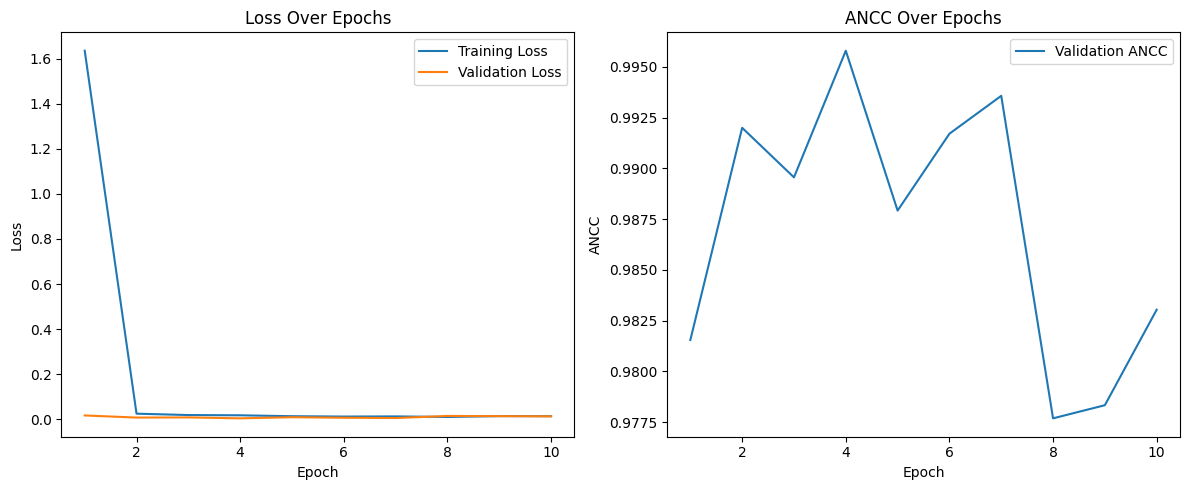

In [51]:
def plot_metrics(train_losses, val_losses, val_anccs, save_path="metrics_plot.png"):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_anccs, label='Validation ANCC')
    plt.xlabel('Epoch')
    plt.ylabel('ANCC')
    plt.title('ANCC Over Epochs')
    plt.legend()
    
    plt.tight_layout()
    
    plt.savefig(save_path)
    plt.show()

plot_metrics(train_losses, val_losses, val_anccs, save_path="metrics_plot.png")

In [52]:
# AI Usage in some places, label_lengths_cpu changed some stuff, and enumerate(zip()). Just wanted it to implement, I just have to port the image if true or false. 
def display_predictions(model, device, data_loader, num_examples=5, output_dir="predictions", mismatched_dir="mismatches"):
    model.eval()
    examples = 0
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(mismatched_dir, exist_ok=True)
    
    mismatches = []  
    
    with torch.no_grad():
        for images, labels, label_lengths in data_loader:
            images = images.to(device)
            outputs = model(images)
            predictions = decode_predictions(outputs)
            
            labels_cpu = labels.cpu().numpy()
            label_lengths_cpu = label_lengths.cpu().numpy()
            idx = 0
            ground_truths = []
            for length in label_lengths_cpu:
                word_indices = labels_cpu[idx:idx+length]
                word = ''.join([idx_to_char[i] for i in word_indices])
                ground_truths.append(word)
                idx += length

            for i, (img, pred, gt) in enumerate(zip(images.cpu(), predictions, ground_truths)):
                if pred != gt:
                    mismatches.append((pred, gt))
                    save_path = os.path.join(mismatched_dir, f"mismatch_{examples + 1}.png")
                else:
                    save_path = os.path.join(output_dir, f"prediction_{examples + 1}.png")
                
                plt.imshow(img.squeeze(0), cmap='gray')
                plt.title(f'Prediction: {pred}\nGround Truth: {gt}')
                plt.axis('off')
                plt.savefig(save_path)
                plt.close()  
                
                examples += 1
                if examples >= num_examples:
                    break
    
    if mismatches:
        print("\nMismatched Predictions:")
        for pred, gt in mismatches:
            print(f"Prediction: {pred} | Ground Truth: {gt}")
    else:
        print("All predictions matched the ground truth.")

In [53]:
display_predictions(model, device, test_loader, num_examples=5, output_dir="predictions", mismatched_dir="mismatches")


Mismatched Predictions:
Prediction: utracentenarianis | Ground Truth: ultracentenarianism
Prediction: kanthian | Ground Truth: xanthian
Prediction: rlowrightia | Ground Truth: plowrightia
Prediction: gsolgotha | Ground Truth: golgotha
